<a href="https://colab.research.google.com/github/harishk1998/HarishBabu_INFO5731_Fall2024/blob/main/Kancharla_Harishbabu_Exercise_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 In-class Exercise 5**

**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## **Question 1 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.


**Algorithms:**

*   MultinominalNB
*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

**Evaluation measurement:**


*   Accuracy
*   Recall
*   Precison
*   F-1 score


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
import warnings

warnings.filterwarnings("ignore")

# File paths
train_file = "/content/stsa-train.txt"
test_file = "/content/stsa-test.txt"

# Check file existence
if not os.path.exists(train_file) or not os.path.exists(test_file):
    print(f"Error: One or both files not found at:\n{train_file}\n{test_file}")
    exit()

print("Both files found! Proceeding with the script.")

# Load data
def load_data(file_path):
    try:
        # Read the raw data
        df = pd.read_csv(file_path, sep="\t", header=None, names=["raw"])
        print(f"Loaded data from {file_path}, sample:\n", df.head())

        # Split into label and text
        df[["label", "text"]] = df["raw"].str.split(" ", n=1, expand=True)  # Split the raw column
        df.drop(columns=["raw"], inplace=True)  # Remove the raw column after splitting
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

train_data = load_data(train_file)
test_data = load_data(test_file)

if train_data is None or test_data is None:
    print("Error: Unable to load datasets. Check file format.")
    exit()

# Inspect loaded data
print("Training Data Sample:")
print(train_data.head())

print("\nTest Data Sample:")
print(test_data.head())

# Data Cleaning
train_data.dropna(subset=["text"], inplace=True)
test_data.dropna(subset=["text"], inplace=True)

train_data["text"] = train_data["text"].astype(str).str.strip()
test_data["text"] = test_data["text"].astype(str).str.strip()

train_data["label"] = train_data["label"].astype(int)
test_data["label"] = test_data["label"].astype(int)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_train_full = vectorizer.fit_transform(train_data["text"])
y_train_full = train_data["label"]
X_test = vectorizer.transform(test_data["text"])
y_test = test_data["label"]

# Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Classifiers
classifiers = {
    "MultinomialNB": MultinomialNB(),
    "SVM": SVC(kernel="linear", probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
}

# Cross-Validation and Evaluation
results = {}
for name, model in classifiers.items():
    print(f"Training and evaluating {name}...")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Use 5 folds for stability
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring="accuracy")
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)

    results[name] = {
        "CV_Accuracy": cv_scores.mean(),
        "Validation_Accuracy": accuracy_score(y_val, y_pred_val),
        "Validation_Precision": precision_score(y_val, y_pred_val),
        "Validation_Recall": recall_score(y_val, y_pred_val),
        "Validation_F1": f1_score(y_val, y_pred_val),
    }

# Final Test Evaluation
best_model_name = max(results, key=lambda x: results[x]["CV_Accuracy"])
best_model = classifiers[best_model_name]
best_model.fit(X_train_full, y_train_full)
y_pred_test = best_model.predict(X_test)

test_results = {
    "Test_Accuracy": accuracy_score(y_test, y_pred_test),
    "Test_Precision": precision_score(y_test, y_pred_test),
    "Test_Recall": recall_score(y_test, y_pred_test),
    "Test_F1": f1_score(y_test, y_pred_test),
}

# Display Results
print("\nValidation Results:")
for model_name, metrics in results.items():
    print(f"{model_name}: {metrics}")

print(f"\nBest Model: {best_model_name}")
print(f"Test Results: {test_results}")


Both files found! Proceeding with the script.
Loaded data from /content/stsa-train.txt, sample:
                                                  raw
0  1 a stirring , funny and finally transporting ...
1  0 apparently reassembled from the cutting-room...
2  0 they presume their audience wo n't sit still...
3  1 this is a visually stunning rumination on lo...
4  1 jonathan parker 's bartleby should have been...
Loaded data from /content/stsa-test.txt, sample:
                                                  raw
0   0 no movement , no yuks , not much of anything .
1  0 a gob of drivel so sickly sweet , even the e...
2  0 gangs of new york is an unapologetic mess , ...
3  0 we never really feel involved with the story...
4          1 this is one of polanski 's best films .
Training Data Sample:
  label                                               text
0     1  a stirring , funny and finally transporting re...
1     0  apparently reassembled from the cutting-room f...
2     0  they pres

## **Question 2 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

**Apply the listed clustering methods to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange



--- Step 1: Loading Dataset ---

Dataset Loaded Successfully
                                        Product Name Brand Name   Price  \
0  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
1  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
2  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
3  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
4  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   

   Rating                                            Reviews  Review Votes  
0       5  I feel so LUCKY to have found this used (phone...           1.0  
1       4  nice phone, nice up grade from my pantach revu...           0.0  
2       5                                       Very pleased           0.0  
3       4  It works good but it goes slow sometimes but i...           0.0  
4       4  Great phone to replace my lost phone. The only...           0.0  

--- Step 2: Cleaning and

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

BERT K-Means Silhouette Score: 0.05

--- Step 8: Visualization of K-Means Clustering ---



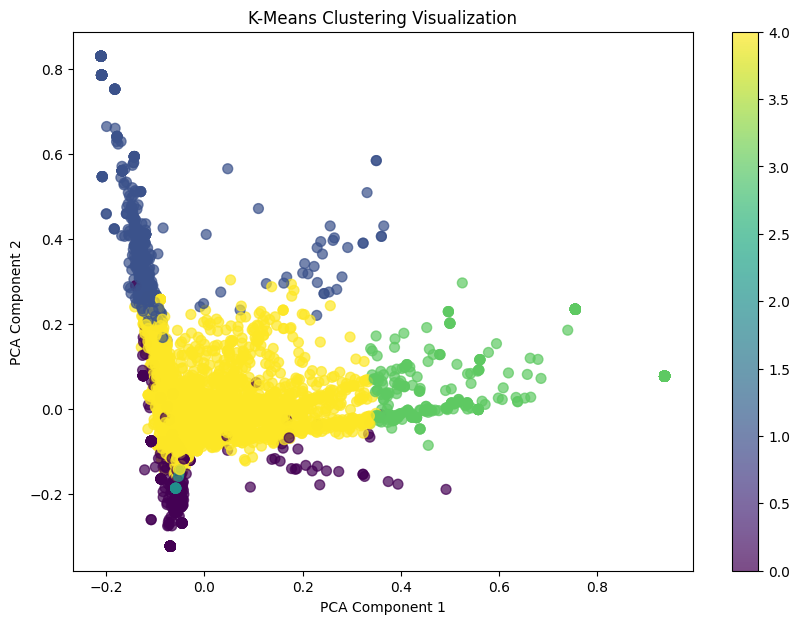

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import IncrementalPCA
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer

# Debugging: Step Indicator
def debug_step(message):
    print(f"\n--- {message} ---\n")

# Step 1: Load Dataset
debug_step("Step 1: Loading Dataset")
data_path = "/content/Amazon_Unlocked_Mobile.csv"
data = pd.read_csv(data_path)
print("Dataset Loaded Successfully")
print(data.head())

# Step 2: Data Cleaning and Sampling
debug_step("Step 2: Cleaning and Sampling Dataset")
data = data.dropna(subset=["Reviews"])
data = data.sample(10000, random_state=42)  # Sample 10,000 reviews
reviews = data["Reviews"].astype(str).values
print(f"Number of Reviews after sampling: {len(reviews)}")

# Step 3: TF-IDF Vectorization
debug_step("Step 3: TF-IDF Vectorization")
vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)  # Reduce dimensionality
tfidf_matrix = vectorizer.fit_transform(reviews)
print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")

# Step 4: Incremental PCA Dimensionality Reduction
debug_step("Step 4: Incremental PCA Dimensionality Reduction")
incremental_pca = IncrementalPCA(n_components=2, batch_size=1000)
reduced_data = incremental_pca.fit_transform(tfidf_matrix.toarray())
print(f"Incremental PCA Reduced Shape: {reduced_data.shape}")

# Step 5: K-Means Clustering
debug_step("Step 5: K-Means Clustering")
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(tfidf_matrix)
kmeans_silhouette = silhouette_score(tfidf_matrix, kmeans_labels)
print(f"K-Means Silhouette Score: {kmeans_silhouette:.2f}")

# Step 6: DBSCAN Clustering
debug_step("Step 6: DBSCAN Clustering")
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(tfidf_matrix)
unique_labels = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"DBSCAN Unique Clusters (excluding noise): {unique_labels}")
if unique_labels > 1:
    dbscan_silhouette = silhouette_score(tfidf_matrix, dbscan_labels)
    print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.2f}")
else:
    print("DBSCAN could not form enough clusters for silhouette scoring.")

# Step 7: BERT Clustering
debug_step("Step 7: BERT Clustering")
bert_model = SentenceTransformer("all-MiniLM-L6-v2")
bert_reviews = reviews[:1000]  # Limit to 1000 samples
bert_embeddings = bert_model.encode(bert_reviews, batch_size=32, show_progress_bar=True)
bert_kmeans = KMeans(n_clusters=5, random_state=42)
bert_kmeans_labels = bert_kmeans.fit_predict(bert_embeddings)
bert_kmeans_silhouette = silhouette_score(bert_embeddings, bert_kmeans_labels)
print(f"BERT K-Means Silhouette Score: {bert_kmeans_silhouette:.2f}")

# Step 8: Visualization of K-Means Clustering
debug_step("Step 8: Visualization of K-Means Clustering")
plt.figure(figsize=(10, 7))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_labels, cmap="viridis", s=50, alpha=0.7)
plt.title("K-Means Clustering Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar()
plt.show()


**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

**Write your response here:**

The results are different for every method because each one works in its own way. K-means did, but the clusters were not very separate (silhouette score 0.05). DBSCAN found 63 clusters, but the score (-0.07) shows it didn’t do a good job, maybe because it needs better parameters. Hierarchical clustering can show how data is connected step by step, but it needs more checking to see if it worked well. Word2Vec and BERT are good at understanding meaning in the text. BERT gave a score of 0.05 with K-means, which means it worked better than others for grouping based on context. So, K-means and BERT are fine, but DBSCAN and hierarchical need more tuning to do better.

.

.

.

.




# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.


**(Your submission will not be graded if this question is left unanswered)**



In [ ]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
Please write you answer here:


This exercise was helpful for me to understand how different clustering methods work and how they give different results depending on
the data and approach. I got a good idea of how to use K-means, DBSCAN, and Hierarchical clustering and how they work with text data.
Trying Word2Vec and BERT was interesting because they gave better context-based clusters. The silhouette scores made it clear which
methods worked well and which didn’t. Overall, this assignment gave me hands-on experience and showed me where I need to focus more,
especially on tuning parameters for better results.


'''